<a href="https://colab.research.google.com/github/AimanSh123/AI-ML-Month/blob/main/Speaker_RecognitionusingDLModels.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
#import librosa
import os
from sklearn.model_selection import train_test_split
from keras.utils import to_categorical
import numpy as np
from tqdm import tqdm

DATA_PATH = "/content/drive/MyDrive/FLask_model/Dataset"

In [ ]:
DATA_PATH

'/content/drive/MyDrive/FLask_model/Dataset'

In [ ]:
# Input: Folder Path
# Output: Tuple (Label, Indices of the labels, one-hot encoded labels)
def get_labels(path=DATA_PATH):
    labels = os.listdir(path)
    label_indices = np.arange(0, len(labels))
    return labels, label_indices, to_categorical(label_indices)

#labels: The list of file and directory names obtained from the specified path or the default DATA_PATH.
# label_indices: An array of indices from 0 to the number of labels.
# to_categorical(label_indices): The one-hot encoded representation of the label indices.


In [ ]:
!pip install librosa

In [ ]:
!pip install pydantic[dotenv]

In [ ]:
#import yaml
import librosa

In [ ]:
# convert file to wav2mfcc
# Mel-frequency cepstral coefficients
def wav2mfcc(file_path, n_mfcc=20, max_len=11):
    wave, sr = librosa.load(file_path, mono=True, sr=None)
    wave = np.asfortranarray(wave[::3])
    mfcc = librosa.feature.mfcc(y=wave, sr=16000, n_mfcc=n_mfcc)

    # If maximum length exceeds mfcc lengths then pad the remaining ones
    if (max_len > mfcc.shape[1]):
        pad_width = max_len - mfcc.shape[1]
        mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')

    # Else cutoff the remaining parts
    else:
        mfcc = mfcc[:, :max_len]

    return mfcc


In [ ]:
import numpy as np
import librosa
from scipy.signal import wiener

def denoise_audio(audio_data):
    # Apply denoising using Wiener filter
    denoised_audio = wiener(audio_data)
    return denoised_audio

def save_data_to_array(path=DATA_PATH, max_len=11, n_mfcc=20):
    labels, _, _ = get_labels(path)

    for label in labels:
        # Init mfcc vectors
        mfcc_vectors = []

        wavfiles = [path + '/' + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
        for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
            # Load the audio file
            wave, sr = librosa.load(wavfile, mono=True, sr=None)

            # Apply denoising using Wiener filter
            denoised_wave = denoise_audio(wave)

            # Resample and downsample the denoised audio
            denoised_wave = np.asfortranarray(denoised_wave[::3])

            # Extract MFCCs from the denoised audio
            mfcc = librosa.feature.mfcc(y=denoised_wave, sr=16000, n_mfcc=n_mfcc)

            # If maximum length exceeds mfcc lengths then pad the remaining ones
            if (max_len > mfcc.shape[1]):
                pad_width = max_len - mfcc.shape[1]
                mfcc = np.pad(mfcc, pad_width=((0, 0), (0, pad_width)), mode='constant')
            # Else cutoff the remaining parts
            else:
                mfcc = mfcc[:, :max_len]

            mfcc_vectors.append(mfcc)

        np.save(label + '.npy', mfcc_vectors)


In [ ]:
# def save_data_to_array(path=DATA_PATH, max_len=11, n_mfcc=20):
#     labels, _, _ = get_labels(path)

#     for label in labels:
#         # Init mfcc vectors
#         mfcc_vectors = []

#         wavfiles = [path + '/' + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]
#         for wavfile in tqdm(wavfiles, "Saving vectors of label - '{}'".format(label)):
#             mfcc = wav2mfcc(wavfile, max_len=max_len, n_mfcc=n_mfcc)
#             mfcc_vectors.append(mfcc)
#         np.save(label + '.npy', mfcc_vectors)


In [ ]:
def get_train_test(split_ratio=0.6, random_state=42):
    # Get available labels
    labels, indices, _ = get_labels(DATA_PATH)

    # Getting first arrays
    X = np.load(labels[0] + '.npy')
    y = np.zeros(X.shape[0])

    # Append all of the dataset into one single array, same goes for y
    for i, label in enumerate(labels[1:]):
        x = np.load(label + '.npy')
        X = np.vstack((X, x))
        y = np.append(y, np.full(x.shape[0], fill_value=(i + 1)))

    assert X.shape[0] == len(y)

    return train_test_split(X, y, test_size=(1 - split_ratio), random_state=random_state, shuffle=True)


In [ ]:
def prepare_dataset(path=DATA_PATH):
    labels, _, _ = get_labels(path)
    data = {}
    for label in labels:
        data[label] = {}
        data[label]['path'] = [path + '/' + label + '/' + wavfile for wavfile in os.listdir(path + '/' + label)]

        vectors = []

        for wavfile in data[label]['path']:
            wave, sr = librosa.load(wavfile, mono=True, sr=None)
            # Downsampling
            wave = wave[::3]
            mfcc = librosa.feature.mfcc(y=wave, sr=16000)
            vectors.append(mfcc)

        data[label]['mfcc'] = vectors

    return data

In [ ]:
def load_dataset(path=DATA_PATH):
    data = prepare_dataset(path)

    dataset = []

    for key in data:
        for mfcc in data[key]['mfcc']:
            dataset.append((key, mfcc))

    return dataset[:100]

In [ ]:
!pip install wandb

     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 2.1/2.1 MB 12.4 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 188.5/188.5 kB 17.0 MB/s eta 0:00:00
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 215.6/215.6 kB 16.7 MB/s eta 0:00:00
  Preparing metadata (setup.py) ... done
     ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 62.7/62.7 kB 7.0 MB/s eta 0:00:00
  Created wheel for pathtools: filename=pathtools-0.1.2-py3-none-any.whl size=8791 sha256=555e90189f1e9c677cef146db8845ec45dd6d64283e93db8511f7ba0691f8a92
  Stored in directory: /root/.cache/pip/wheels/e7/f3/22/152153d6eb222ee7a56ff8617d80ee5207207a8c00a7aab794
Successfully built pathtools


In [ ]:
# print(prepare_dataset(DATA_PATH))
from keras.models import Sequential
from keras.layers import Dense, Dropout, Flatten, Conv2D, MaxPooling2D, LSTM
from keras.utils import to_categorical
import wandb
from wandb.keras import WandbCallback
import matplotlib.pyplot as plt

wandb.init()
config = wandb.config

config.max_len = 64
config.buckets = 22

# Save data to array file first
save_data_to_array(max_len=config.max_len, n_mfcc=config.buckets)

# labels=["down", "go", "left", "no", "off","on","right","stop","up","yes","present"]
labels = ["zero","one","two","three","four","five","six","seven","eight","nine"]
          #  264e3dd0f984bacda1dc9e1a08a26605aca76ee3

<IPython.core.display.Javascript object>

wandb: Logging into wandb.ai. (Learn how to deploy a W&B server locally: https://wandb.me/wandb-server)
wandb: You can find your API key in your browser here: https://wandb.ai/authorize
wandb: Paste an API key from your profile and hit enter, or press ctrl+c to quit:

 ··········


wandb: Appending key for api.wandb.ai to your netrc file: /root/.netrc


Saving vectors of label - '00_Aiman':   0%|          | 0/66 [00:00<?, ?it/s]/usr/local/lib/python3.10/dist-packages/scipy/signal/_signaltools.py:1629: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/usr/local/lib/python3.10/dist-packages/scipy/signal/_signaltools.py:1629: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
Saving vectors of label - '00_Aiman':   2%|▏         | 1/66 [00:10<10:51, 10.03s/it]/usr/local/lib/python3.10/dist-packages/scipy/signal/_signaltools.py:1629: RuntimeWarning: divide by zero encountered in true_divide
  res *= (1 - noise / lVar)
/usr/local/lib/python3.10/dist-packages/scipy/signal/_signaltools.py:1629: RuntimeWarning: invalid value encountered in multiply
  res *= (1 - noise / lVar)
Saving vectors of label - '04_Danish': 100%|██████████| 58/58 [00:32<00:00,  1.79it/s]


In [ ]:
# # Loading train set and test set
X_train, X_test, y_train, y_test = get_train_test()

In [ ]:
channels = 1
config.epochs = 50 #50
config.batch_size = 100 #100

num_classes = 5

X_train = X_train.reshape(X_train.shape[0], config.buckets, config.max_len, channels)
X_test = X_test.reshape(X_test.shape[0], config.buckets, config.max_len, channels)

In [ ]:
print(X_train.shape)

(189, 22, 64, 1)


3.0


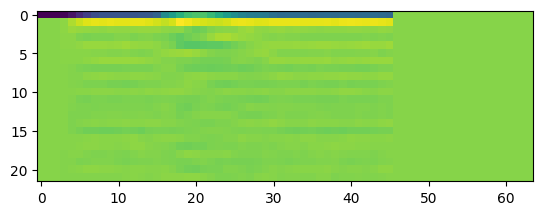

In [ ]:
plt.imshow(X_train[100, :, :, 0])
print(y_train[100])

In [ ]:
y_train_hot = to_categorical(y_train)
y_test_hot = to_categorical(y_test)

X_train = X_train.reshape(X_train.shape[0], config.buckets, config.max_len)
X_test = X_test.reshape(X_test.shape[0], config.buckets, config.max_len)

LSTM RNN

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dense

# Define the model
# model = Sequential()
# model.add(LSTM(64, input_shape=(config.buckets, config.max_len))) # 64 is the number of LSTM units
# model.add(Dense(4, activation='sigmoid')) # Output layer with sigmoid activation
model = Sequential()
model.add(LSTM(64, input_shape=(config.buckets, config.max_len), return_sequences=True))
model.add(SimpleRNN(64, return_sequences=False))
model.add(Dense(5))


# Compile the model
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the modelwandb.init()
x=model.fit(X_train, y_train_hot, epochs=config.epochs, validation_data=(X_test, y_test_hot), callbacks=[WandbCallback(data_type="audio", labels=labels)])
print(x)


wandb: WARNING The save_model argument by default saves the model in the HDF5 format that cannot save custom objects like subclassed models and custom layers. This behavior will be deprecated in a future release in favor of the SavedModel format. Meanwhile, the HDF5 model is saved as W&B files and the SavedModel as W&B Artifacts.
wandb: WARNING The data_type argument of wandb.keras.WandbCallback is deprecated and will be removed in a future release. Please use input_type instead.
wandb: WARNING Setting input_type = data_type.


Epoch 1/50
6/6 [==============================] - ETA: 0s - loss: 1.3302 - accuracy: 0.3598

wandb: Adding directory to artifact (/content/wandb/run-20230804_122034-e9kndx6z/files/model-best)... Done. 0.0s


6/6 [==============================] - 25s 3s/step - loss: 1.3302 - accuracy: 0.3598 - val_loss: 1.3147 - val_accuracy: 0.4094
Epoch 2/50
6/6 [==============================] - ETA: 0s - loss: 0.9770 - accuracy: 0.5079

wandb: Adding directory to artifact (/content/wandb/run-20230804_122034-e9kndx6z/files/model-best)... Done. 0.0s


6/6 [==============================] - 13s 3s/step - loss: 0.9770 - accuracy: 0.5079 - val_loss: 1.1617 - val_accuracy: 0.4646
Epoch 3/50
6/6 [==============================] - ETA: 0s - loss: 0.7846 - accuracy: 0.5291

wandb: Adding directory to artifact (/content/wandb/run-20230804_122034-e9kndx6z/files/model-best)... Done. 0.0s


6/6 [==============================] - 10s 2s/step - loss: 0.7846 - accuracy: 0.5291 - val_loss: 1.0310 - val_accuracy: 0.4567
Epoch 4/50
6/6 [==============================] - ETA: 0s - loss: 0.5952 - accuracy: 0.6243

wandb: Adding directory to artifact (/content/wandb/run-20230804_122034-e9kndx6z/files/model-best)... Done. 0.0s


6/6 [==============================] - 9s 2s/step - loss: 0.5952 - accuracy: 0.6243 - val_loss: 0.9481 - val_accuracy: 0.5039
Epoch 5/50
5/6 [========================>.....] - ETA: 0s - loss: 0.5062 - accuracy: 0.7312

wandb: Adding directory to artifact (/content/wandb/run-20230804_122034-e9kndx6z/files/model-best)... Done. 0.0s


6/6 [==============================] - 16s 3s/step - loss: 0.5515 - accuracy: 0.7196 - val_loss: 0.8457 - val_accuracy: 0.5669
Epoch 6/50
6/6 [==============================] - ETA: 0s - loss: 0.4871 - accuracy: 0.7354

wandb: Adding directory to artifact (/content/wandb/run-20230804_122034-e9kndx6z/files/model-best)... Done. 0.0s


6/6 [==============================] - 9s 2s/step - loss: 0.4871 - accuracy: 0.7354 - val_loss: 0.7547 - val_accuracy: 0.5906
Epoch 7/50
5/6 [========================>.....] - ETA: 0s - loss: 0.4424 - accuracy: 0.7437

wandb: Adding directory to artifact (/content/wandb/run-20230804_122034-e9kndx6z/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.4610 - accuracy: 0.7460 - val_loss: 0.6948 - val_accuracy: 0.5984
Epoch 8/50
6/6 [==============================] - ETA: 0s - loss: 0.4354 - accuracy: 0.7196

wandb: Adding directory to artifact (/content/wandb/run-20230804_122034-e9kndx6z/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 1s/step - loss: 0.4354 - accuracy: 0.7196 - val_loss: 0.6320 - val_accuracy: 0.5669
Epoch 9/50
5/6 [========================>.....] - ETA: 0s - loss: 0.4425 - accuracy: 0.7312

wandb: Adding directory to artifact (/content/wandb/run-20230804_122034-e9kndx6z/files/model-best)... Done. 0.0s


6/6 [==============================] - 7s 1s/step - loss: 0.4254 - accuracy: 0.7196 - val_loss: 0.5998 - val_accuracy: 0.6142
Epoch 10/50
5/6 [========================>.....] - ETA: 0s - loss: 0.3844 - accuracy: 0.7500

wandb: Adding directory to artifact (/content/wandb/run-20230804_122034-e9kndx6z/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 1s/step - loss: 0.4061 - accuracy: 0.7513 - val_loss: 0.5765 - val_accuracy: 0.5906
Epoch 11/50
5/6 [========================>.....] - ETA: 0s - loss: 0.3705 - accuracy: 0.7625

wandb: Adding directory to artifact (/content/wandb/run-20230804_122034-e9kndx6z/files/model-best)... Done. 0.0s


6/6 [==============================] - 7s 1s/step - loss: 0.3872 - accuracy: 0.7354 - val_loss: 0.5734 - val_accuracy: 0.5906
Epoch 12/50
4/6 [===================>..........] - ETA: 0s - loss: 0.3860 - accuracy: 0.7422

wandb: Adding directory to artifact (/content/wandb/run-20230804_122034-e9kndx6z/files/model-best)... Done. 0.0s


6/6 [==============================] - 7s 1s/step - loss: 0.3655 - accuracy: 0.7513 - val_loss: 0.5662 - val_accuracy: 0.6299
Epoch 13/50
6/6 [==============================] - ETA: 0s - loss: 0.3615 - accuracy: 0.7513

wandb: Adding directory to artifact (/content/wandb/run-20230804_122034-e9kndx6z/files/model-best)... Done. 0.0s


6/6 [==============================] - 7s 1s/step - loss: 0.3615 - accuracy: 0.7513 - val_loss: 0.5616 - val_accuracy: 0.6299
Epoch 14/50
6/6 [==============================] - ETA: 0s - loss: 0.3601 - accuracy: 0.7566

wandb: Adding directory to artifact (/content/wandb/run-20230804_122034-e9kndx6z/files/model-best)... Done. 0.0s


6/6 [==============================] - 8s 2s/step - loss: 0.3601 - accuracy: 0.7566 - val_loss: 0.5583 - val_accuracy: 0.6299
Epoch 15/50
6/6 [==============================] - 0s 37ms/step - loss: 0.3616 - accuracy: 0.7143 - val_loss: 0.5592 - val_accuracy: 0.5906
Epoch 16/50
5/6 [========================>.....] - ETA: 0s - loss: 0.3336 - accuracy: 0.7437

wandb: Adding directory to artifact (/content/wandb/run-20230804_122034-e9kndx6z/files/model-best)... Done. 0.0s


6/6 [==============================] - 7s 1s/step - loss: 0.3452 - accuracy: 0.7513 - val_loss: 0.5537 - val_accuracy: 0.6299
Epoch 17/50
6/6 [==============================] - ETA: 0s - loss: 0.3410 - accuracy: 0.7725

wandb: Adding directory to artifact (/content/wandb/run-20230804_122034-e9kndx6z/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.3410 - accuracy: 0.7725 - val_loss: 0.5515 - val_accuracy: 0.6299
Epoch 18/50
6/6 [==============================] - ETA: 0s - loss: 0.3288 - accuracy: 0.7672

wandb: Adding directory to artifact (/content/wandb/run-20230804_122034-e9kndx6z/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.3288 - accuracy: 0.7672 - val_loss: 0.5514 - val_accuracy: 0.5906
Epoch 19/50
6/6 [==============================] - ETA: 0s - loss: 0.3288 - accuracy: 0.7407

wandb: Adding directory to artifact (/content/wandb/run-20230804_122034-e9kndx6z/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.3288 - accuracy: 0.7407 - val_loss: 0.5481 - val_accuracy: 0.6299
Epoch 20/50
6/6 [==============================] - 0s 36ms/step - loss: 0.3136 - accuracy: 0.7725 - val_loss: 0.5506 - val_accuracy: 0.5827
Epoch 21/50
6/6 [==============================] - 0s 33ms/step - loss: 0.3143 - accuracy: 0.7407 - val_loss: 0.5482 - val_accuracy: 0.6378
Epoch 22/50
6/6 [==============================] - 0s 35ms/step - loss: 0.3102 - accuracy: 0.7831 - val_loss: 0.5528 - val_accuracy: 0.5984
Epoch 23/50
6/6 [==============================] - ETA: 0s - loss: 0.3092 - accuracy: 0.7725

wandb: Adding directory to artifact (/content/wandb/run-20230804_122034-e9kndx6z/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.3092 - accuracy: 0.7725 - val_loss: 0.5309 - val_accuracy: 0.5906
Epoch 24/50
6/6 [==============================] - ETA: 0s - loss: 0.3073 - accuracy: 0.7725

wandb: Adding directory to artifact (/content/wandb/run-20230804_122034-e9kndx6z/files/model-best)... Done. 0.0s


6/6 [==============================] - 7s 1s/step - loss: 0.3073 - accuracy: 0.7725 - val_loss: 0.5295 - val_accuracy: 0.6378
Epoch 25/50
6/6 [==============================] - 0s 35ms/step - loss: 0.3069 - accuracy: 0.7884 - val_loss: 0.5309 - val_accuracy: 0.6299
Epoch 26/50
6/6 [==============================] - 0s 37ms/step - loss: 0.3083 - accuracy: 0.7884 - val_loss: 0.5348 - val_accuracy: 0.6299
Epoch 27/50
6/6 [==============================] - 0s 37ms/step - loss: 0.3059 - accuracy: 0.7989 - val_loss: 0.5526 - val_accuracy: 0.5906
Epoch 28/50
6/6 [==============================] - 0s 48ms/step - loss: 0.3077 - accuracy: 0.7725 - val_loss: 0.5539 - val_accuracy: 0.5906
Epoch 29/50
6/6 [==============================] - 0s 74ms/step - loss: 0.3061 - accuracy: 0.7778 - val_loss: 0.5524 - val_accuracy: 0.6299
Epoch 30/50
6/6 [==============================] - 0s 36ms/step - loss: 0.3069 - accuracy: 0.7884 - val_loss: 0.5397 - val_accuracy: 0.6299
Epoch 31/50
6/6 [=================

In [ ]:
# Evaluate the model
loss, accuracy = model.evaluate(X_test, y_test_hot)

# # Make predictions
# predictions = model.predict(X_test)

4/4 [==============================] - 0s 7ms/step - loss: 0.5605 - accuracy: 0.5906


In [ ]:
test_error, test_accuracy = model.evaluate(X_test, y_test_hot)
print(f"Test error: {test_error}, test_accuracy: {test_accuracy}")

4/4 [==============================] - 0s 7ms/step - loss: 0.5605 - accuracy: 0.5906
Test error: 0.5604835748672485, test_accuracy: 0.5905511975288391


In [ ]:
predictions = model.predict(X_test)

# Convert predictions to binary values (if necessary)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = (binary_predictions == y_test_hot).mean()

# Print the accuracy
print("Accuracy:", accuracy)


4/4 [==============================] - 0s 6ms/step
Accuracy: 0.84251968503937


LSTM

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, SimpleRNN, Dense

In [ ]:
model = Sequential()
model.add(LSTM(128, input_shape=(config.buckets, config.max_len)))  # Adjust input shape as per your data
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

In [ ]:
wandb.init()
x=model.fit(X_train, y_train_hot, epochs=config.epochs, validation_data=(X_test, y_test_hot), callbacks=[WandbCallback(data_type="audio", labels=labels)])
print(x)

accuracy,▁▃▄▅▇▇▇▇▇▇▇▇▇█▇▇▇███████▇▇███████▇██████
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▆▄▃▂▂▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▃▂▄▇▇▆▇▇█████▇██▇▇██▇▇█▇███▇████▇██▇██▇
val_loss,█▇▅▅▃▂▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.77249
best_epoch,23
best_val_loss,0.52945
epoch,49
loss,0.30723
val_accuracy,0.59055


Epoch 1/50
1/6 [====>.........................] - ETA: 14s - loss: 1.6668 - accuracy: 0.4062

wandb: Adding directory to artifact (/content/wandb/run-20230804_122701-5htvodn9/files/model-best)... Done. 0.0s


6/6 [==============================] - 9s 1s/step - loss: 1.4673 - accuracy: 0.4392 - val_loss: 1.1557 - val_accuracy: 0.6929
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 1.1732 - accuracy: 0.5938

wandb: Adding directory to artifact (/content/wandb/run-20230804_122701-5htvodn9/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 991ms/step - loss: 0.9847 - accuracy: 0.6984 - val_loss: 0.8612 - val_accuracy: 0.7008
Epoch 3/50
1/6 [====>.........................] - ETA: 0s - loss: 0.7247 - accuracy: 0.7500

wandb: Adding directory to artifact (/content/wandb/run-20230804_122701-5htvodn9/files/model-best)... Done. 0.0s


6/6 [==============================] - 4s 803ms/step - loss: 0.6279 - accuracy: 0.7778 - val_loss: 0.6274 - val_accuracy: 0.7087
Epoch 4/50
1/6 [====>.........................] - ETA: 0s - loss: 0.5068 - accuracy: 0.8125

wandb: Adding directory to artifact (/content/wandb/run-20230804_122701-5htvodn9/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 1s/step - loss: 0.4499 - accuracy: 0.7989 - val_loss: 0.5606 - val_accuracy: 0.7559
Epoch 5/50
1/6 [====>.........................] - ETA: 0s - loss: 0.4720 - accuracy: 0.6875

wandb: Adding directory to artifact (/content/wandb/run-20230804_122701-5htvodn9/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 996ms/step - loss: 0.3850 - accuracy: 0.7725 - val_loss: 0.5328 - val_accuracy: 0.7638
Epoch 6/50
1/6 [====>.........................] - ETA: 0s - loss: 0.3852 - accuracy: 0.7812

wandb: Adding directory to artifact (/content/wandb/run-20230804_122701-5htvodn9/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.3486 - accuracy: 0.7672 - val_loss: 0.5124 - val_accuracy: 0.7795
Epoch 7/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2772 - accuracy: 0.8750

wandb: Adding directory to artifact (/content/wandb/run-20230804_122701-5htvodn9/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.3292 - accuracy: 0.8095 - val_loss: 0.5011 - val_accuracy: 0.7795
Epoch 8/50
1/6 [====>.........................] - ETA: 0s - loss: 0.3824 - accuracy: 0.7812

wandb: Adding directory to artifact (/content/wandb/run-20230804_122701-5htvodn9/files/model-best)... Done. 0.0s


6/6 [==============================] - 4s 824ms/step - loss: 0.3131 - accuracy: 0.8042 - val_loss: 0.4969 - val_accuracy: 0.7480
Epoch 9/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2994 - accuracy: 0.7812

wandb: Adding directory to artifact (/content/wandb/run-20230804_122701-5htvodn9/files/model-best)... Done. 0.0s


6/6 [==============================] - 4s 797ms/step - loss: 0.3053 - accuracy: 0.7778 - val_loss: 0.4870 - val_accuracy: 0.7874
Epoch 10/50
1/6 [====>.........................] - ETA: 0s - loss: 0.4219 - accuracy: 0.7500

wandb: Adding directory to artifact (/content/wandb/run-20230804_122701-5htvodn9/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.3023 - accuracy: 0.8095 - val_loss: 0.4834 - val_accuracy: 0.7874
Epoch 11/50
6/6 [==============================] - 0s 15ms/step - loss: 0.2949 - accuracy: 0.8042 - val_loss: 0.4851 - val_accuracy: 0.7480
Epoch 12/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2524 - accuracy: 0.8750

wandb: Adding directory to artifact (/content/wandb/run-20230804_122701-5htvodn9/files/model-best)... Done. 0.0s


6/6 [==============================] - 4s 799ms/step - loss: 0.2942 - accuracy: 0.7831 - val_loss: 0.4770 - val_accuracy: 0.7795
Epoch 13/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2507 - accuracy: 0.8438

wandb: Adding directory to artifact (/content/wandb/run-20230804_122701-5htvodn9/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 905ms/step - loss: 0.2905 - accuracy: 0.8095 - val_loss: 0.4739 - val_accuracy: 0.7795
Epoch 14/50
6/6 [==============================] - 0s 14ms/step - loss: 0.3016 - accuracy: 0.7407 - val_loss: 0.4747 - val_accuracy: 0.7402
Epoch 15/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2469 - accuracy: 0.8750

wandb: Adding directory to artifact (/content/wandb/run-20230804_122701-5htvodn9/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.2953 - accuracy: 0.7831 - val_loss: 0.4691 - val_accuracy: 0.7874
Epoch 16/50
6/6 [==============================] - 0s 16ms/step - loss: 0.2885 - accuracy: 0.7937 - val_loss: 0.4718 - val_accuracy: 0.7402
Epoch 17/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2506 - accuracy: 0.8125

wandb: Adding directory to artifact (/content/wandb/run-20230804_122701-5htvodn9/files/model-best)... Done. 0.0s


6/6 [==============================] - 4s 829ms/step - loss: 0.2853 - accuracy: 0.7937 - val_loss: 0.4679 - val_accuracy: 0.7795
Epoch 18/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2038 - accuracy: 0.7500

wandb: Adding directory to artifact (/content/wandb/run-20230804_122701-5htvodn9/files/model-best)... Done. 0.0s


6/6 [==============================] - 4s 787ms/step - loss: 0.2846 - accuracy: 0.7249 - val_loss: 0.4660 - val_accuracy: 0.7795
Epoch 19/50
1/6 [====>.........................] - ETA: 0s - loss: 0.3337 - accuracy: 0.7500

wandb: Adding directory to artifact (/content/wandb/run-20230804_122701-5htvodn9/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.2830 - accuracy: 0.8095 - val_loss: 0.4645 - val_accuracy: 0.7795
Epoch 20/50
6/6 [==============================] - 0s 14ms/step - loss: 0.2838 - accuracy: 0.8095 - val_loss: 0.4650 - val_accuracy: 0.7795
Epoch 21/50
6/6 [==============================] - 0s 15ms/step - loss: 0.2821 - accuracy: 0.7884 - val_loss: 0.4647 - val_accuracy: 0.7795
Epoch 22/50
1/6 [====>.........................] - ETA: 0s - loss: 0.3051 - accuracy: 0.8438

wandb: Adding directory to artifact (/content/wandb/run-20230804_122701-5htvodn9/files/model-best)... Done. 0.0s


6/6 [==============================] - 4s 802ms/step - loss: 0.2823 - accuracy: 0.8095 - val_loss: 0.4634 - val_accuracy: 0.7795
Epoch 23/50
6/6 [==============================] - 0s 16ms/step - loss: 0.2827 - accuracy: 0.7778 - val_loss: 0.4667 - val_accuracy: 0.7402
Epoch 24/50
6/6 [==============================] - 0s 14ms/step - loss: 0.2822 - accuracy: 0.7831 - val_loss: 0.4635 - val_accuracy: 0.7795
Epoch 25/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2569 - accuracy: 0.9062

wandb: Adding directory to artifact (/content/wandb/run-20230804_122701-5htvodn9/files/model-best)... Done. 0.0s


6/6 [==============================] - 4s 802ms/step - loss: 0.2841 - accuracy: 0.8095 - val_loss: 0.4625 - val_accuracy: 0.7795
Epoch 26/50
6/6 [==============================] - 0s 13ms/step - loss: 0.2788 - accuracy: 0.8201 - val_loss: 0.4657 - val_accuracy: 0.7402
Epoch 27/50
6/6 [==============================] - 0s 13ms/step - loss: 0.2806 - accuracy: 0.7725 - val_loss: 0.4645 - val_accuracy: 0.7402
Epoch 28/50
6/6 [==============================] - 0s 17ms/step - loss: 0.2836 - accuracy: 0.7937 - val_loss: 0.4639 - val_accuracy: 0.7795
Epoch 29/50
1/6 [====>.........................] - ETA: 0s - loss: 0.3289 - accuracy: 0.6562

wandb: Adding directory to artifact (/content/wandb/run-20230804_122701-5htvodn9/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.2803 - accuracy: 0.7937 - val_loss: 0.4621 - val_accuracy: 0.7795
Epoch 30/50
1/6 [====>.........................] - ETA: 0s - loss: 0.3916 - accuracy: 0.6875

wandb: Adding directory to artifact (/content/wandb/run-20230804_122701-5htvodn9/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 964ms/step - loss: 0.2808 - accuracy: 0.8095 - val_loss: 0.4615 - val_accuracy: 0.7874
Epoch 31/50
6/6 [==============================] - 0s 15ms/step - loss: 0.2791 - accuracy: 0.8095 - val_loss: 0.4639 - val_accuracy: 0.7402
Epoch 32/50
6/6 [==============================] - 0s 14ms/step - loss: 0.2785 - accuracy: 0.7884 - val_loss: 0.4637 - val_accuracy: 0.7795
Epoch 33/50
6/6 [==============================] - 0s 15ms/step - loss: 0.2788 - accuracy: 0.8095 - val_loss: 0.4624 - val_accuracy: 0.7795
Epoch 34/50
6/6 [==============================] - 0s 12ms/step - loss: 0.2779 - accuracy: 0.8095 - val_loss: 0.4631 - val_accuracy: 0.7795
Epoch 35/50
6/6 [==============================] - 0s 15ms/step - loss: 0.2805 - accuracy: 0.8095 - val_loss: 0.4622 - val_accuracy: 0.7795
Epoch 36/50
6/6 [==============================] - 0s 12ms/step - loss: 0.2806 - accuracy: 0.7725 - val_loss: 0.4644 - val_accuracy: 0.7795
Epoch 37/50
6/6 [==============

In [ ]:
predictions = model.predict(X_test)

# Convert predictions to binary values (if necessary)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = (binary_predictions == y_test_hot).mean()

# Print the accuracy
print("Accuracy:", accuracy)

4/4 [==============================] - 0s 4ms/step
Accuracy: 0.8960629921259843


LSTM MAM

In [ ]:
model = Sequential()
model.add(Flatten(input_shape=(config.buckets, config.max_len)))
model.add(Dense(num_classes, activation='softmax'))
model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

In [ ]:
# build model
model = Sequential()
model.add(LSTM(32, input_shape=(config.buckets, config.max_len), activation="tanh")) #changes done
model.add(Dense(32, activation='tanh'))
model.add(Dense(num_classes, activation='softmax'))

In [ ]:
model.compile(loss="categorical_crossentropy",
                  optimizer="adam",
                  metrics=['accuracy'])

In [ ]:
wandb.init()
x=model.fit(X_train, y_train_hot, epochs=config.epochs, validation_data=(X_test, y_test_hot), callbacks=[WandbCallback(data_type="audio", labels=labels)])
print(x)

accuracy,▁▆▇█▇██▇█▇█▇██▆█▇█▇▇█▇███▇██▇███▆▇███▇█▇
epoch,▁▁▁▁▂▂▂▂▂▃▃▃▃▃▃▄▄▄▄▄▅▅▅▅▅▅▆▆▆▆▆▆▇▇▇▇▇███
loss,█▅▃▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
val_accuracy,▁▂▂▆▇▇▅█▅▇▇▄▄▇▇▇▇▇▄▇▄▄▇▇▄▇▇▇▇▇▇▇▇▇▇▇▇▄▇▄
val_loss,█▅▃▂▂▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁▁
accuracy,0.74603
best_epoch,29
best_val_loss,0.46152
epoch,49
loss,0.28537
val_accuracy,0.74016


Epoch 1/50
1/6 [====>.........................] - ETA: 12s - loss: 1.5982 - accuracy: 0.2812

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 8s 998ms/step - loss: 1.5410 - accuracy: 0.2646 - val_loss: 1.5224 - val_accuracy: 0.4016
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 1.4246 - accuracy: 0.5625

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 1.3632 - accuracy: 0.5503 - val_loss: 1.4154 - val_accuracy: 0.4724
Epoch 3/50
1/6 [====>.........................] - ETA: 0s - loss: 1.3624 - accuracy: 0.5625

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 4s 816ms/step - loss: 1.2291 - accuracy: 0.6772 - val_loss: 1.3202 - val_accuracy: 0.5118
Epoch 4/50
1/6 [====>.........................] - ETA: 0s - loss: 1.1966 - accuracy: 0.6562

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 910ms/step - loss: 1.1052 - accuracy: 0.7249 - val_loss: 1.2149 - val_accuracy: 0.5669
Epoch 5/50
1/6 [====>.........................] - ETA: 0s - loss: 1.0591 - accuracy: 0.7500

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.9724 - accuracy: 0.7460 - val_loss: 1.1021 - val_accuracy: 0.5984
Epoch 6/50
1/6 [====>.........................] - ETA: 0s - loss: 0.8937 - accuracy: 0.6875

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 4s 828ms/step - loss: 0.8301 - accuracy: 0.7619 - val_loss: 0.9808 - val_accuracy: 0.6142
Epoch 7/50
1/6 [====>.........................] - ETA: 0s - loss: 0.7878 - accuracy: 0.8438

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 966ms/step - loss: 0.6947 - accuracy: 0.7778 - val_loss: 0.8933 - val_accuracy: 0.6220
Epoch 8/50
1/6 [====>.........................] - ETA: 0s - loss: 0.6232 - accuracy: 0.8438

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.5993 - accuracy: 0.7778 - val_loss: 0.8336 - val_accuracy: 0.6850
Epoch 9/50
1/6 [====>.........................] - ETA: 0s - loss: 0.5466 - accuracy: 0.8750

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 4s 839ms/step - loss: 0.5392 - accuracy: 0.8042 - val_loss: 0.7949 - val_accuracy: 0.6929
Epoch 10/50
1/6 [====>.........................] - ETA: 0s - loss: 0.4831 - accuracy: 0.7500

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 981ms/step - loss: 0.4957 - accuracy: 0.8042 - val_loss: 0.7664 - val_accuracy: 0.6929
Epoch 11/50
1/6 [====>.........................] - ETA: 0s - loss: 0.4302 - accuracy: 0.9062

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.4579 - accuracy: 0.8042 - val_loss: 0.7420 - val_accuracy: 0.7087
Epoch 12/50
1/6 [====>.........................] - ETA: 0s - loss: 0.4410 - accuracy: 0.7812

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 4s 846ms/step - loss: 0.4293 - accuracy: 0.8095 - val_loss: 0.7216 - val_accuracy: 0.7087
Epoch 13/50
1/6 [====>.........................] - ETA: 0s - loss: 0.4705 - accuracy: 0.7812

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 992ms/step - loss: 0.4057 - accuracy: 0.8095 - val_loss: 0.7064 - val_accuracy: 0.7008
Epoch 14/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2601 - accuracy: 0.9375

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.3869 - accuracy: 0.8095 - val_loss: 0.6945 - val_accuracy: 0.6929
Epoch 15/50
1/6 [====>.........................] - ETA: 0s - loss: 0.4786 - accuracy: 0.8125

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.3714 - accuracy: 0.8095 - val_loss: 0.6828 - val_accuracy: 0.6929
Epoch 16/50
1/6 [====>.........................] - ETA: 0s - loss: 0.3298 - accuracy: 0.8438

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.3595 - accuracy: 0.8095 - val_loss: 0.6721 - val_accuracy: 0.6929
Epoch 17/50
1/6 [====>.........................] - ETA: 0s - loss: 0.3722 - accuracy: 0.8125

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 988ms/step - loss: 0.3482 - accuracy: 0.8095 - val_loss: 0.6638 - val_accuracy: 0.6929
Epoch 18/50
1/6 [====>.........................] - ETA: 0s - loss: 0.3222 - accuracy: 0.7812

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 4s 830ms/step - loss: 0.3405 - accuracy: 0.7884 - val_loss: 0.6576 - val_accuracy: 0.6614
Epoch 19/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2474 - accuracy: 0.8125

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.3334 - accuracy: 0.8095 - val_loss: 0.6485 - val_accuracy: 0.7008
Epoch 20/50
1/6 [====>.........................] - ETA: 0s - loss: 0.3470 - accuracy: 0.8438

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 4s 808ms/step - loss: 0.3293 - accuracy: 0.8095 - val_loss: 0.6409 - val_accuracy: 0.7087
Epoch 21/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2552 - accuracy: 0.8438

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 976ms/step - loss: 0.3242 - accuracy: 0.7619 - val_loss: 0.6385 - val_accuracy: 0.6693
Epoch 22/50
1/6 [====>.........................] - ETA: 0s - loss: 0.3696 - accuracy: 0.6875

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.3177 - accuracy: 0.7831 - val_loss: 0.6324 - val_accuracy: 0.7165
Epoch 23/50
1/6 [====>.........................] - ETA: 0s - loss: 0.3038 - accuracy: 0.7812

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 4s 824ms/step - loss: 0.3138 - accuracy: 0.8095 - val_loss: 0.6275 - val_accuracy: 0.7323
Epoch 24/50
1/6 [====>.........................] - ETA: 0s - loss: 0.3135 - accuracy: 0.7812

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 967ms/step - loss: 0.3109 - accuracy: 0.8095 - val_loss: 0.6245 - val_accuracy: 0.7402
Epoch 25/50
1/6 [====>.........................] - ETA: 0s - loss: 0.4184 - accuracy: 0.7812

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.3083 - accuracy: 0.8095 - val_loss: 0.6201 - val_accuracy: 0.7323
Epoch 26/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2990 - accuracy: 0.7500

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 961ms/step - loss: 0.3052 - accuracy: 0.8095 - val_loss: 0.6172 - val_accuracy: 0.7323
Epoch 27/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2713 - accuracy: 0.8125

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 4s 876ms/step - loss: 0.3031 - accuracy: 0.8095 - val_loss: 0.6147 - val_accuracy: 0.7323
Epoch 28/50
1/6 [====>.........................] - ETA: 0s - loss: 0.3054 - accuracy: 0.8125

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.3011 - accuracy: 0.8095 - val_loss: 0.6129 - val_accuracy: 0.7323
Epoch 29/50
1/6 [====>.........................] - ETA: 0s - loss: 0.3261 - accuracy: 0.8125

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 4s 831ms/step - loss: 0.2998 - accuracy: 0.8095 - val_loss: 0.6118 - val_accuracy: 0.7323
Epoch 30/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2277 - accuracy: 0.9062

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 1s/step - loss: 0.2982 - accuracy: 0.8095 - val_loss: 0.6098 - val_accuracy: 0.7323
Epoch 31/50
1/6 [====>.........................] - ETA: 0s - loss: 0.1992 - accuracy: 0.8750

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.2967 - accuracy: 0.8095 - val_loss: 0.6086 - val_accuracy: 0.7323
Epoch 32/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2167 - accuracy: 0.8750

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 4s 835ms/step - loss: 0.2959 - accuracy: 0.8095 - val_loss: 0.6076 - val_accuracy: 0.7323
Epoch 33/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2924 - accuracy: 0.9062

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 1s/step - loss: 0.2952 - accuracy: 0.8095 - val_loss: 0.6055 - val_accuracy: 0.7323
Epoch 34/50
1/6 [====>.........................] - ETA: 0s - loss: 0.3424 - accuracy: 0.7500

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 1s/step - loss: 0.2934 - accuracy: 0.8095 - val_loss: 0.6047 - val_accuracy: 0.7323
Epoch 35/50
1/6 [====>.........................] - ETA: 0s - loss: 0.3432 - accuracy: 0.7812

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 4s 832ms/step - loss: 0.2926 - accuracy: 0.8095 - val_loss: 0.6033 - val_accuracy: 0.7323
Epoch 36/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2715 - accuracy: 0.8750

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 1s/step - loss: 0.2938 - accuracy: 0.8095 - val_loss: 0.6018 - val_accuracy: 0.7323
Epoch 37/50
6/6 [==============================] - 0s 19ms/step - loss: 0.2946 - accuracy: 0.7725 - val_loss: 0.6037 - val_accuracy: 0.6929
Epoch 38/50
1/6 [====>.........................] - ETA: 0s - loss: 0.3005 - accuracy: 0.7812

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 1s/step - loss: 0.2907 - accuracy: 0.7884 - val_loss: 0.6008 - val_accuracy: 0.7244
Epoch 39/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2917 - accuracy: 0.8750

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 4s 823ms/step - loss: 0.2901 - accuracy: 0.8095 - val_loss: 0.5995 - val_accuracy: 0.7244
Epoch 40/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2271 - accuracy: 0.9062

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 6s 1s/step - loss: 0.2907 - accuracy: 0.8095 - val_loss: 0.5983 - val_accuracy: 0.7244
Epoch 41/50
6/6 [==============================] - 0s 23ms/step - loss: 0.2891 - accuracy: 0.8095 - val_loss: 0.5990 - val_accuracy: 0.7244
Epoch 42/50
6/6 [==============================] - 0s 22ms/step - loss: 0.2902 - accuracy: 0.7619 - val_loss: 0.5996 - val_accuracy: 0.6850
Epoch 43/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2975 - accuracy: 0.7500

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 997ms/step - loss: 0.2899 - accuracy: 0.7937 - val_loss: 0.5962 - val_accuracy: 0.7244
Epoch 44/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2913 - accuracy: 0.8125

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 952ms/step - loss: 0.2881 - accuracy: 0.8095 - val_loss: 0.5956 - val_accuracy: 0.7244
Epoch 45/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2915 - accuracy: 0.8125

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 1s/step - loss: 0.2868 - accuracy: 0.8095 - val_loss: 0.5955 - val_accuracy: 0.7244
Epoch 46/50
6/6 [==============================] - 0s 21ms/step - loss: 0.2881 - accuracy: 0.7672 - val_loss: 0.5973 - val_accuracy: 0.6850
Epoch 47/50
6/6 [==============================] - 0s 18ms/step - loss: 0.2880 - accuracy: 0.7937 - val_loss: 0.5975 - val_accuracy: 0.6850
Epoch 48/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2751 - accuracy: 0.7500

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 5s 961ms/step - loss: 0.2866 - accuracy: 0.8095 - val_loss: 0.5940 - val_accuracy: 0.7244
Epoch 49/50
1/6 [====>.........................] - ETA: 0s - loss: 0.2284 - accuracy: 0.8438

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 4s 849ms/step - loss: 0.2868 - accuracy: 0.8095 - val_loss: 0.5932 - val_accuracy: 0.7244
Epoch 50/50
6/6 [==============================] - 0s 14ms/step - loss: 0.2850 - accuracy: 0.8095 - val_loss: 0.5935 - val_accuracy: 0.7244


In [ ]:
predictions = model.predict(X_test)

# Convert predictions to binary values (if necessary)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = (binary_predictions == y_test_hot).mean()

# Print the accuracy
print("Accuracy:", accuracy)

4/4 [==============================] - 0s 4ms/step
Accuracy: 0.8913385826771654


In [ ]:
test_error, test_accuracy = model.evaluate(X_test, y_test_hot)
print(f"Test error: {test_error}, test_accuracy: {test_accuracy}")

4/4 [==============================] - 0s 5ms/step - loss: 0.5935 - accuracy: 0.7244
Test error: 0.5935237407684326, test_accuracy: 0.7244094610214233


GRU

In [ ]:
from keras.models import Sequential
from keras.layers import LSTM, GRU, Dense
import numpy as np

In [ ]:
model = Sequential()
model.add(LSTM(64, input_shape=(config.buckets, config.max_len), return_sequences=True))
model.add(GRU(64, return_sequences=False))
model.add(Dense(5))

# Compile the model
model.compile(loss='mean_squared_error', optimizer='adam')

# Train the model
x=model.fit(X_train, y_train_hot, epochs=config.epochs, validation_data=(X_test, y_test_hot), callbacks=[WandbCallback(data_type="audio", labels=labels)])

# Make predictions
# predictions = model.predict(X_test)

# Print the predictions
# print(predictions)


Epoch 1/50
1/6 [====>.........................] - ETA: 24s - loss: 0.2631

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 13s 2s/step - loss: 0.1919 - val_loss: 0.1440
Epoch 2/50
1/6 [====>.........................] - ETA: 0s - loss: 0.1346

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 10s 2s/step - loss: 0.1165 - val_loss: 0.1112
Epoch 3/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0981

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 8s 2s/step - loss: 0.0814 - val_loss: 0.0903
Epoch 4/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0420

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 8s 2s/step - loss: 0.0602 - val_loss: 0.0856
Epoch 5/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0498

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 9s 2s/step - loss: 0.0536 - val_loss: 0.0816
Epoch 6/50
6/6 [==============================] - ETA: 0s - loss: 0.0483

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 7s 1s/step - loss: 0.0483 - val_loss: 0.0794
Epoch 7/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0330

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 9s 2s/step - loss: 0.0455 - val_loss: 0.0783
Epoch 8/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0479

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 7s 1s/step - loss: 0.0436 - val_loss: 0.0781
Epoch 9/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0507

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 9s 2s/step - loss: 0.0422 - val_loss: 0.0780
Epoch 10/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0400

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 7s 1s/step - loss: 0.0415 - val_loss: 0.0776
Epoch 11/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0325

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 9s 2s/step - loss: 0.0409 - val_loss: 0.0773
Epoch 12/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0406 - val_loss: 0.0774
Epoch 13/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0310

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 7s 1s/step - loss: 0.0402 - val_loss: 0.0771
Epoch 14/50
6/6 [==============================] - 0s 29ms/step - loss: 0.0401 - val_loss: 0.0772
Epoch 15/50
6/6 [==============================] - ETA: 0s - loss: 0.0402

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 9s 2s/step - loss: 0.0402 - val_loss: 0.0771
Epoch 16/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0329

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 8s 2s/step - loss: 0.0398 - val_loss: 0.0770
Epoch 17/50
6/6 [==============================] - 0s 31ms/step - loss: 0.0400 - val_loss: 0.0770
Epoch 18/50
6/6 [==============================] - 0s 23ms/step - loss: 0.0398 - val_loss: 0.0771
Epoch 19/50
6/6 [==============================] - 0s 23ms/step - loss: 0.0401 - val_loss: 0.0773
Epoch 20/50
6/6 [==============================] - 0s 20ms/step - loss: 0.0398 - val_loss: 0.0771
Epoch 21/50
6/6 [==============================] - ETA: 0s - loss: 0.0398

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 8s 2s/step - loss: 0.0398 - val_loss: 0.0770
Epoch 22/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0397 - val_loss: 0.0770
Epoch 23/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0397 - val_loss: 0.0771
Epoch 24/50
1/6 [====>.........................] - ETA: 0s - loss: 0.0297

wandb: Adding directory to artifact (/content/wandb/run-20230804_122935-jeplt2ww/files/model-best)... Done. 0.0s


6/6 [==============================] - 8s 2s/step - loss: 0.0398 - val_loss: 0.0769
Epoch 25/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0397 - val_loss: 0.0770
Epoch 26/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0399 - val_loss: 0.0774
Epoch 27/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0399 - val_loss: 0.0773
Epoch 28/50
6/6 [==============================] - 0s 16ms/step - loss: 0.0398 - val_loss: 0.0770
Epoch 29/50
6/6 [==============================] - 0s 17ms/step - loss: 0.0397 - val_loss: 0.0771
Epoch 30/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0400 - val_loss: 0.0773
Epoch 31/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0398 - val_loss: 0.0772
Epoch 32/50
6/6 [==============================] - 0s 15ms/step - loss: 0.0398 - val_loss: 0.0770
Epoch 33/50
6/6 [==============================] - 0s 14ms/step - loss: 0.0397 - val_loss: 0.0771
Epoch 34/50
6/6 [=================

In [ ]:
predictions = model.predict(X_test)

# Convert predictions to binary values (if necessary)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = (binary_predictions == y_test_hot).mean()

# Print the accuracy
print("Accuracy:", accuracy)

4/4 [==============================] - 1s 5ms/step
Accuracy: 0.889763779527559


In [ ]:
test_loss = model.evaluate(X_test, y_test_hot)
test_accuracy = 1 - test_loss  # Assuming you're calculating accuracy as (1 - loss)

print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")

4/4 [==============================] - 0s 6ms/step - loss: 0.0774
Test loss: 0.0773736983537674, Test accuracy: 0.9226263016462326


CNN

In [ ]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D, Flatten, Dense, Dropout

# Assuming your input data is X_train and X_test with shape (num_samples, height, width)

# Reshape the data to have a single channel
X_train = X_train.reshape(X_train.shape[0], X_train.shape[1], X_train.shape[2], 1)
X_test = X_test.reshape(X_test.shape[0], X_test.shape[1], X_test.shape[2], 1)

# Build the CNN model
model = Sequential()
model.add(Conv2D(32, (3, 3), activation='relu', input_shape=(X_train.shape[1], X_train.shape[2], 1)))
model.add(MaxPooling2D((2, 2)))
model.add(Conv2D(64, (3, 3), activation='relu'))
model.add(MaxPooling2D((2, 2)))
model.add(Flatten())
model.add(Dense(128, activation='relu'))
model.add(Dropout(0.5))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# Train the model
x = model.fit(X_train, y_train_hot, epochs=config.epochs, validation_data=(X_test, y_test_hot), callbacks=[WandbCallback(data_type="audio", labels=labels)])
print(x)



Epoch 1/50
6/6 [==============================] - 9s 118ms/step - loss: 7.8969 - accuracy: 0.4339 - val_loss: 2.6422 - val_accuracy: 0.6693
Epoch 2/50
6/6 [==============================] - 0s 28ms/step - loss: 2.2875 - accuracy: 0.6720 - val_loss: 0.9221 - val_accuracy: 0.7323
Epoch 3/50
6/6 [==============================] - 0s 18ms/step - loss: 0.7281 - accuracy: 0.7619 - val_loss: 0.5744 - val_accuracy: 0.8031
Epoch 4/50
6/6 [==============================] - 0s 18ms/step - loss: 0.5572 - accuracy: 0.7619 - val_loss: 0.4422 - val_accuracy: 0.7638
Epoch 5/50
6/6 [==============================] - 0s 19ms/step - loss: 0.4024 - accuracy: 0.7460 - val_loss: 0.3868 - val_accuracy: 0.8110
Epoch 6/50
6/6 [==============================] - 0s 18ms/step - loss: 0.3635 - accuracy: 0.7831 - val_loss: 0.3845 - val_accuracy: 0.8110
Epoch 7/50
6/6 [==============================] - 0s 21ms/step - loss: 0.3602 - accuracy: 0.7778 - val_loss: 0.3883 - val_accuracy: 0.7717
Epoch 8/50
6/6 [==========

In [ ]:
predictions = model.predict(X_test)

# Convert predictions to binary values (if necessary)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = (binary_predictions == y_test_hot).mean()

# Print the accuracy
print("Accuracy:", accuracy)

4/4 [==============================] - 0s 3ms/step
Accuracy: 0.9244094488188976


In [ ]:
# Assuming you have already trained the model and have X_test and y_test_hot ready

# Evaluate the model
test_results = model.evaluate(X_test, y_test_hot)

# Extract the loss and accuracy from the test_results list
test_loss = test_results[0]
test_accuracy = 1 - test_results[1]  # Assuming the second element is the accuracy (1 - accuracy)

print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")


4/4 [==============================] - 0s 7ms/step - loss: 0.5738 - accuracy: 0.8110
Test loss: 0.5738465785980225, Test accuracy: 0.18897640705108643


TDNN

In [ ]:
import numpy as np
import keras
from keras.models import Sequential
from keras.layers import Conv1D, MaxPooling1D, Flatten, Dense

# Build the TDNN model
model = Sequential()
model.add(Conv1D(64, 3, activation='relu', input_shape=(config.buckets, config.max_len)))
model.add(MaxPooling1D(2))
model.add(Conv1D(128, 3, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Flatten())
model.add(Dense(256, activation='relu'))
model.add(Dense(num_classes, activation='softmax'))

# Compile the model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

x=model.fit(X_train, y_train_hot, epochs=config.epochs, validation_data=(X_test, y_test_hot), callbacks=[WandbCallback(data_type="audio", labels=labels)])
print(x)


Epoch 1/50
6/6 [==============================] - 3s 114ms/step - loss: 11.7972 - accuracy: 0.5079 - val_loss: 8.6769 - val_accuracy: 0.6535
Epoch 2/50
6/6 [==============================] - 0s 20ms/step - loss: 7.2138 - accuracy: 0.5926 - val_loss: 4.0054 - val_accuracy: 0.7402
Epoch 3/50
6/6 [==============================] - 0s 20ms/step - loss: 1.6454 - accuracy: 0.7725 - val_loss: 2.2494 - val_accuracy: 0.7559
Epoch 4/50
6/6 [==============================] - 0s 20ms/step - loss: 0.5738 - accuracy: 0.7989 - val_loss: 1.6934 - val_accuracy: 0.7953
Epoch 5/50
6/6 [==============================] - 0s 21ms/step - loss: 0.8939 - accuracy: 0.7619 - val_loss: 1.8385 - val_accuracy: 0.7795
Epoch 6/50
6/6 [==============================] - 0s 19ms/step - loss: 0.7304 - accuracy: 0.8307 - val_loss: 2.3943 - val_accuracy: 0.7953
Epoch 7/50
6/6 [==============================] - 0s 21ms/step - loss: 0.9873 - accuracy: 0.8201 - val_loss: 1.1956 - val_accuracy: 0.7953
Epoch 8/50
6/6 [=========

In [ ]:
predictions = model.predict(X_test)

# Convert predictions to binary values (if necessary)
binary_predictions = (predictions > 0.5).astype(int)

# Calculate accuracy
accuracy = (binary_predictions == y_test_hot).mean()

# Print the accuracy
print("Accuracy:", accuracy)

4/4 [==============================] - 0s 4ms/step
Accuracy: 0.9181102362204724


In [ ]:
# Assuming you have already trained the model and have X_test and y_test_hot ready

# Evaluate the model
test_results = model.evaluate(X_test, y_test_hot)

# Extract the loss and accuracy from the test_results list
test_loss = test_results[0]
test_accuracy = test_results[1]

print(f"Test loss: {test_loss}, Test accuracy: {test_accuracy}")


4/4 [==============================] - 0s 9ms/step - loss: 0.6536 - accuracy: 0.7953
Test loss: 0.6535815000534058, Test accuracy: 0.7952755689620972
